## 프로젝트 개요 

- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 - AI데이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : 캐글 대회 Bike Sharing Demand 데이터를 활용한 수요 예측 대회
- 프로젝트 마감일 : 2022년 7월 19일 화요일
- 수강생명 : 정상

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib 
import calendar 
from scipy import stats
import missingno as msno
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


import os

## 데이터 불러오기 

In [3]:
DATA_PATH = '/kaggle/input/bike-sharing-demand/'
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
submission = pd.read_csv(DATA_PATH + 'sampleSubmission.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
df = train.copy()

## 결측치 유무 확인

<AxesSubplot:>

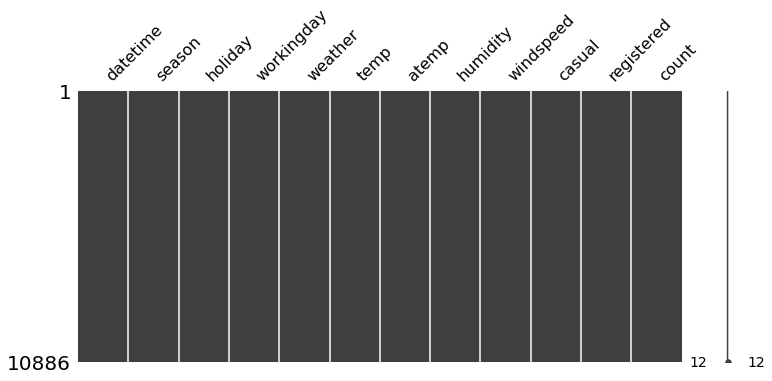

In [5]:
msno.matrix(train, figsize=(12,5))

## 이상치확인 

Text(0.5, 1.0, 'count')

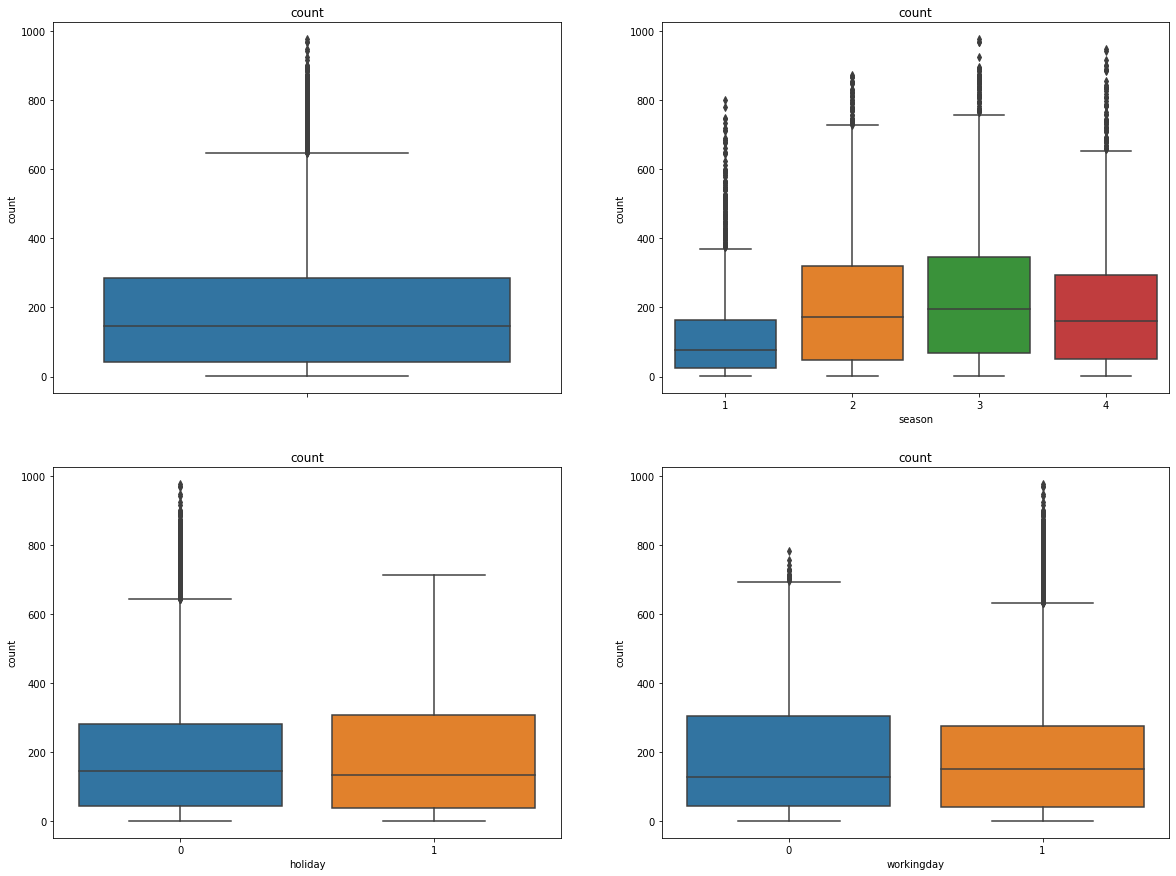

In [6]:
# count자체와 season,holiday,workingday를 box플롯으로 시각화
fig, ax=plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20,15)
sns.boxplot(y='count', data=train, orient='v', ax= ax[0,0])
ax[0,0].set_title('count')
sns.boxplot(x='season',y='count', data=train, orient='v', ax= ax[0,1])
ax[0,1].set_title('count')
sns.boxplot(x='holiday',y='count', data=train, orient='v', ax= ax[1,0])
ax[1,0].set_title('count')
sns.boxplot(x='workingday',y='count', data=train, orient='v', ax= ax[1,1])
ax[1,1].set_title('count')

### 이상치 제거 

In [7]:
# count 칼럼의 이상치 제거 
trainWithOutliers = train[np.abs(train["count"]-train['count'].mean())<= (3*train['count'].std())]

In [8]:
print ("Shape Of The Before Ouliers: ",train.shape)
print ("Shape Of The After Ouliers: ",trainWithOutliers.shape)

Shape Of The Before Ouliers:  (10886, 12)
Shape Of The After Ouliers:  (10739, 12)


### 데이터 가공전 상관관계 분석 

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


<AxesSubplot:>

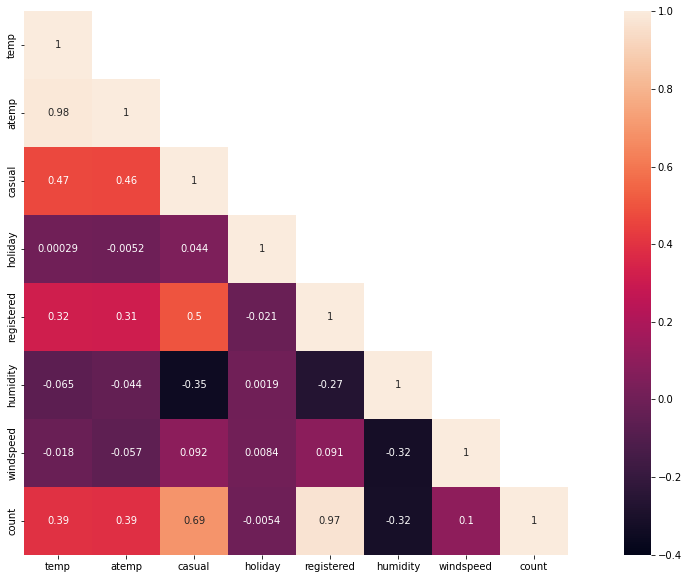

In [10]:
# 각각의 컬럼별 상관관계 시각화
CorrMat = train[['temp','atemp','casual','holiday','registered','humidity', 'windspeed','count']].corr()
mask=np.array(CorrMat)
mask[np.tril_indices_from(mask)] = False
fig = plt.figure(figsize=[20,10])
sns.heatmap(CorrMat,mask=mask,vmax=1,vmin=-0.4,annot=True,square=True)

## 시간데이터 처리

In [11]:
# 시간데이터를 년,달,일,시,평일로 분리
import time
import datetime
train['date']= pd.to_datetime(train['datetime'])
train['year']= train['date'].dt.year
train['month']=train['date'].dt.month
train['day']=train['date'].dt.day
train['hour']=train['date'].dt.hour
train['weekday']=train['date'].dt.day_name()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  object        
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  date        10886 non-null  datetime64[ns]
 13  year        10886 non-null  int64         
 14  month       10886 non-null  int64         
 15  day         10886 non-null  int64         
 16  hour        10886 non-

### 필요가 없어진 date 삭제

In [13]:
# date컬럼이 이제 필요없으니 삭제
train = train.drop('date', axis=1)

### count값과 뽑아낸 컬럼들간의 관계 파악

Text(0.5, 1.0, 'hour')

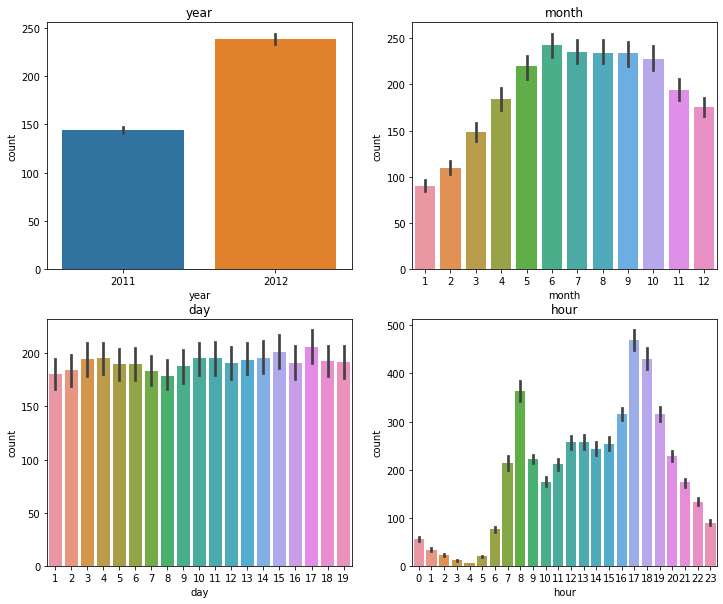

In [14]:
fig, ax = plt.subplots(nrows=2,ncols=2,)
fig.set_size_inches(12,10)


sns.barplot(x='year',y='count',data=train,ax=ax[0,0])
ax[0,0].set_title('year')
sns.barplot(x='month',y='count',data=train,ax=ax[0,1])
ax[0,1].set_title('month')
sns.barplot(x='day',y='count',data=train,ax=ax[1,0])
ax[1,0].set_title('day')
sns.barplot(x='hour',y='count',data=train,ax=ax[1,1])
ax[1,1].set_title('hour')

### 날씨, 계절, 작업일, 휴일과 count관계 파악

Text(0.5, 1.0, 'holiday')

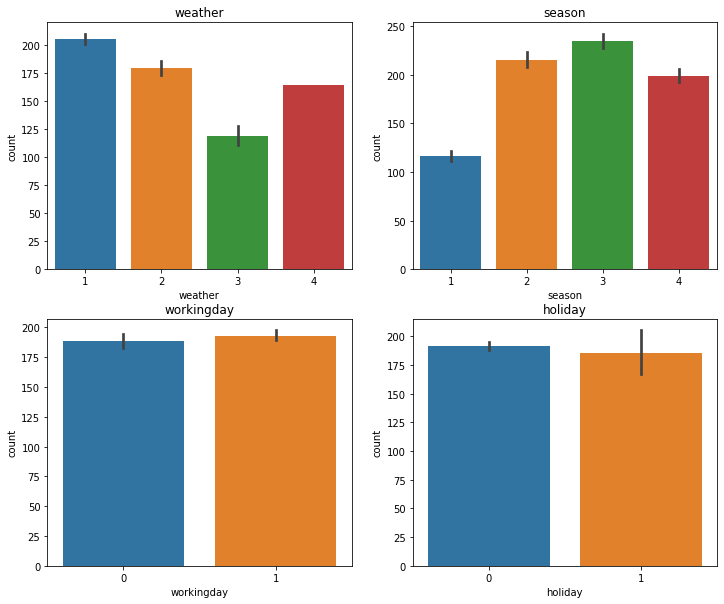

In [15]:
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12,10)

sns.barplot(x='weather',y='count',data=train,ax=ax[0,0])
ax[0,0].set_title('weather')
sns.barplot(x='season',y='count',data=train,ax=ax[0,1])
ax[0,1].set_title('season')
sns.barplot(x='workingday',y='count',data=train,ax=ax[1,0])
ax[1,0].set_title('workingday')
sns.barplot(x='holiday',y='count',data=train,ax=ax[1,1])
ax[1,1].set_title('holiday')

In [16]:
def badToRight(month):
    if month in [12,1,2]:
        return 4
    elif month in [3,4,5]:
        return 1
    elif month in [6,7,8]:
        return 2
    elif month in [9,10,11]:
        return 3

train['season'] = train.month.apply(badToRight)

Text(0.5, 1.0, 'holiday')

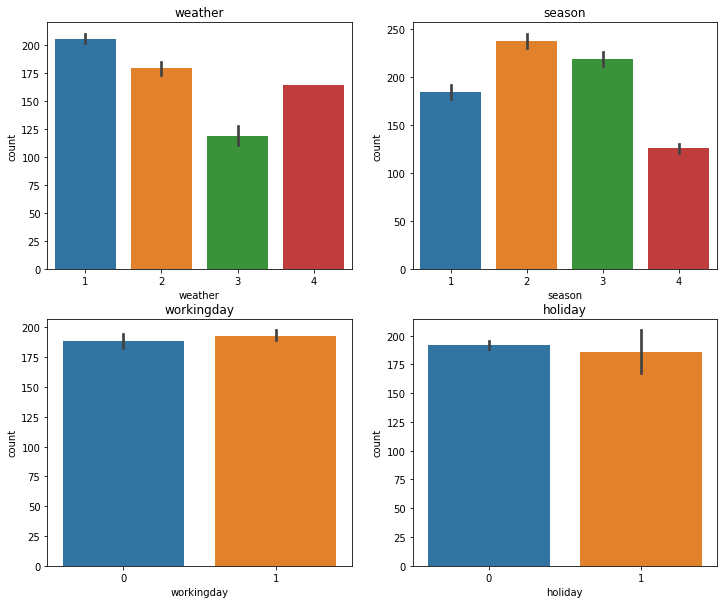

In [17]:
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12,10)

sns.barplot(x='weather',y='count',data=train,ax=ax[0,0])
ax[0,0].set_title('weather')
sns.barplot(x='season',y='count',data=train,ax=ax[0,1])
ax[0,1].set_title('season')
sns.barplot(x='workingday',y='count',data=train,ax=ax[1,0])
ax[1,0].set_title('workingday')
sns.barplot(x='holiday',y='count',data=train,ax=ax[1,1])
ax[1,1].set_title('holiday')

# 남은칼럼과 count와 비교

<AxesSubplot:xlabel='windspeed', ylabel='count'>

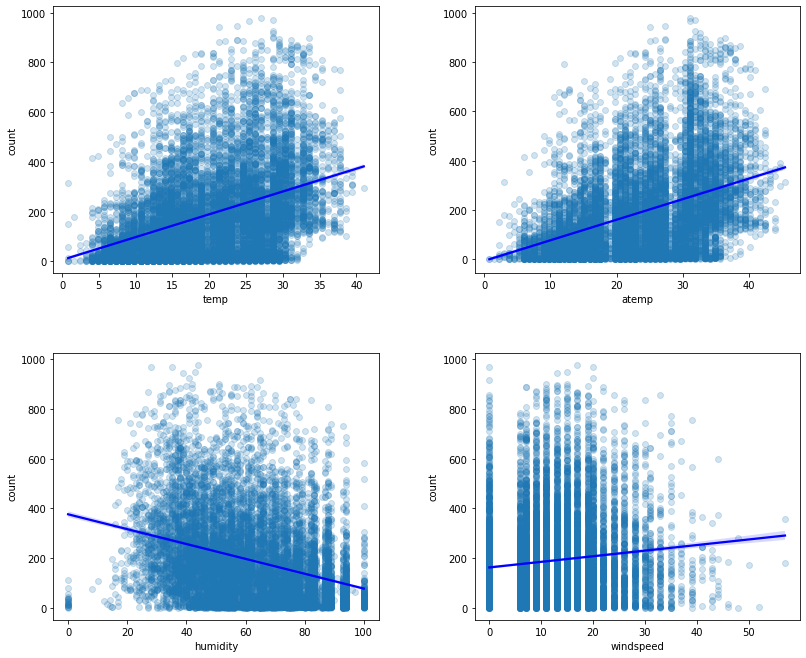

In [18]:
fig, ax = plt.subplots(nrows=2,ncols=2)

fig.tight_layout()
fig.set_size_inches(12,10)

sns.regplot(x='temp', y='count', data = train, scatter_kws = {'alpha':0.2}, line_kws={'color':'blue'}, ax=ax[0,0])
sns.regplot(x='atemp', y='count', data = train, scatter_kws = {'alpha':0.2}, line_kws={'color':'blue'}, ax=ax[0,1])
sns.regplot(x='humidity', y='count', data = train, scatter_kws = {'alpha':0.2}, line_kws={'color':'blue'}, ax=ax[1,0])
sns.regplot(x='windspeed', y='count', data = train, scatter_kws = {'alpha':0.2}, line_kws={'color':'blue'}, ax=ax[1,1])

### 상관계수 시각화

<AxesSubplot:>

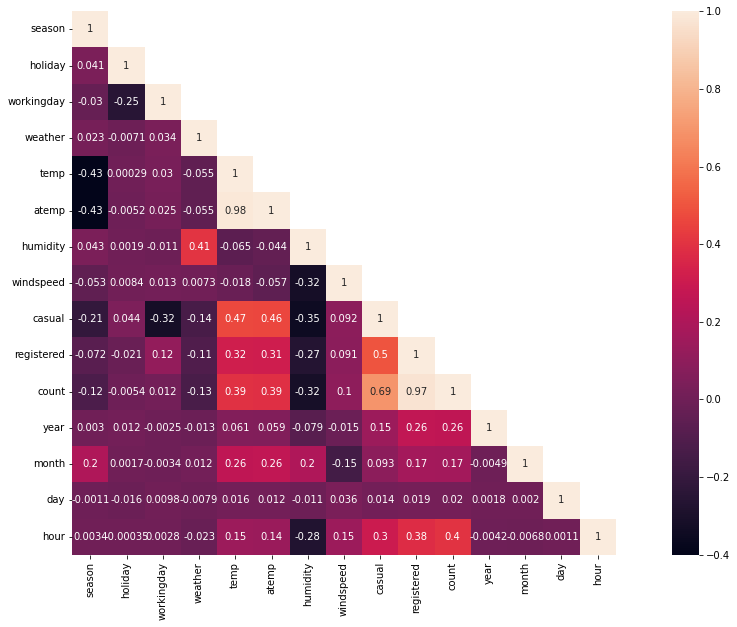

In [19]:
CorrMat = train.corr()
mask = np.array(CorrMat)
mask[np.tril_indices_from(mask)] = False
fig = plt.figure(figsize=[20,10])
sns.heatmap(CorrMat,mask=mask,vmin=-0.4,annot=True,square=True)

## count의 표준화

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.        , 0.        , 0.        , ..., 6.59578051, 6.5971457 ,
         6.59850903])),
 (1.40968461015429, 4.523106928071492, 0.9537631807794262))

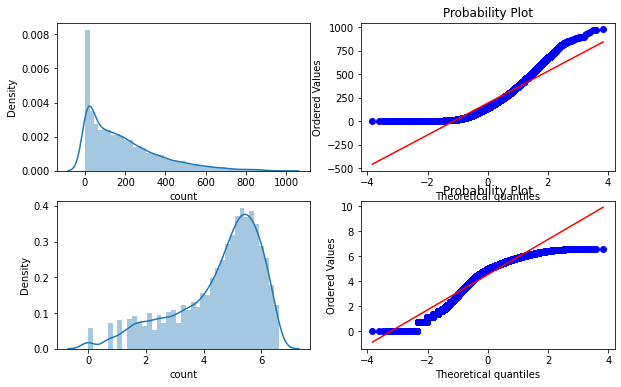

In [20]:
fig, ax = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(10,6)
sns.distplot(train['count'], ax=ax[0,0])
stats.probplot(train['count'],dist='norm',fit=True,plot=ax[0,1])
sns.distplot(np.log(trainWithOutliers['count']),ax=ax[1,0])
stats.probplot(np.log(trainWithOutliers['count']),dist='norm',fit=True,plot=ax[1,1])

### 히트맵을 보고 두개의 컬럼 시각화 

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
 12  year        10886 non-null  int64  
 13  month       10886 non-null  int64  
 14  day         10886 non-null  int64  
 15  hour        10886 non-null  int64  
 16  weekday     10886 non-null  object 
dtypes: float64(3), int64(12), object(2)
memory usage: 1.4+ MB


<AxesSubplot:xlabel='hour', ylabel='count'>

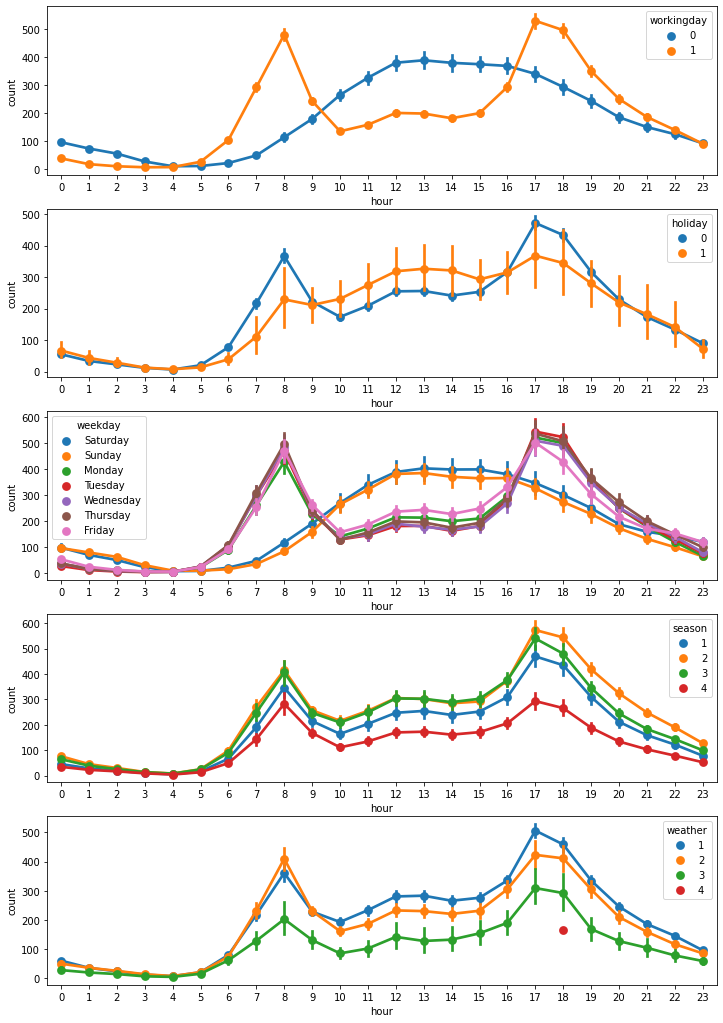

In [22]:
fig, ax = plt.subplots(nrows = 5)

## 전체 그래프 기본설정
#  전체 그래프 사이즈 관리
fig.set_size_inches(12,18)

# 시간과 카운트에 대해 시각화
sns.pointplot(x = 'hour', y ='count', hue = 'workingday', data = train, ax=ax[0])
sns.pointplot(x = 'hour', y ='count', hue = 'holiday', data = train, ax=ax[1])
sns.pointplot(x = 'hour', y ='count', hue = 'weekday', data = train, ax=ax[2])
sns.pointplot(x = 'hour', y ='count', hue = 'season', data = train, ax=ax[3])
sns.pointplot(x = 'hour', y ='count', hue = 'weather', data = train, ax=ax[4])

- train의 weather값이 이상함을 발견

In [23]:
# 전체데이터중 weather=4인값 확
train[train.weather == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
5631,2012-01-09 18:00:00,4,0,1,4,8.2,11.365,86,6.0032,6,158,164,2012,1,9,18,Monday


<AxesSubplot:xlabel='month', ylabel='count'>

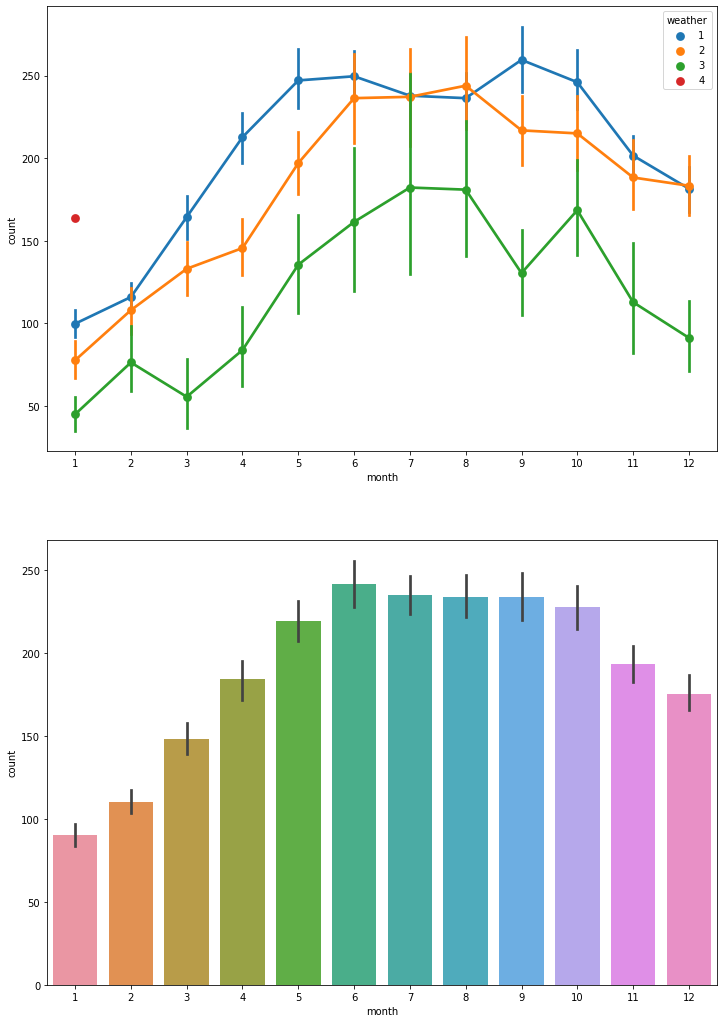

In [24]:
fig, ax = plt.subplots(nrows = 2)

## 전체 그래프 기본설정
#  전체 그래프 사이즈 관리
fig.set_size_inches(12,18)

sns.pointplot(x = 'month', y ='count', hue = 'weather', data = train, ax=ax[0])
sns.barplot(x = 'month', y ='count', data = train, ax=ax[1])

- windspeed는 0인값이 많은데 이는 0이었는지 측정하지못해서 0인지 두개의 경우가있다, 우리는 후자의 경우를 사용한다.

In [25]:
# 0 : Sunday -> 6: saturday
# 머린러닝을 위해서 숫자로 변환해준다
train['weekday']= train.weekday.astype('category')
train.weekday.cat.categories =['5','1','6','0','4','2','3']

### RandomForest로 Windspeed값 부여
- 데이터를 windspeed == 0, windspeed != 0로 분리
- 학습시킬 데이터 중 0이아닌 데이터프레임에서는 Windspeed만 담긴 Series와 학습시킬 column들의 데이터프레임으로 분리
- 학습 후 Windspeed가 0인 데이터프레임에서 학습시킨 컬럼과 같게 추출해서 값을 부여받은 후, windspeed가 0인 데이터 프레임에 부여

In [26]:
# Windspeed = 0
windspeed_0 = train[train.windspeed == 0]
# Windspeed != 0
windspeed_not0 = train[train.windspeed != 0]

# windspeed=0인 프레임에 미포함
windspeed_0_df = windspeed_0.drop(['windspeed','casual','registered','count','datetime'], axis=1)

# windspeed!=0인 데이터프렘인은 위와 동일하게 만들고, 학습시킬 Windspeed Series를 그대로 둠
windspeed_not0_df = windspeed_not0.drop(['windspeed','casual','registered','count','datetime'], axis=1)
windspeed_not0_series = windspeed_not0['windspeed']

# 0이아닌 데이터프레임과 결과값인 시리즈 학습
rf = RandomForestRegressor()
rf.fit(windspeed_not0_df,windspeed_not0_series)

predict_windspeed_0 = rf.predict(windspeed_0_df)
windspeed_0['windspeed'] = predict_windspeed_0

In [27]:
# windspeed_0와 windspeed_not0를 다시 합치기
train=pd.concat([windspeed_0,windspeed_not0],axis =0)

In [28]:
# 합쳐진 데이터 datetime순 정렬
train = train.sort_values(by=['datetime'])

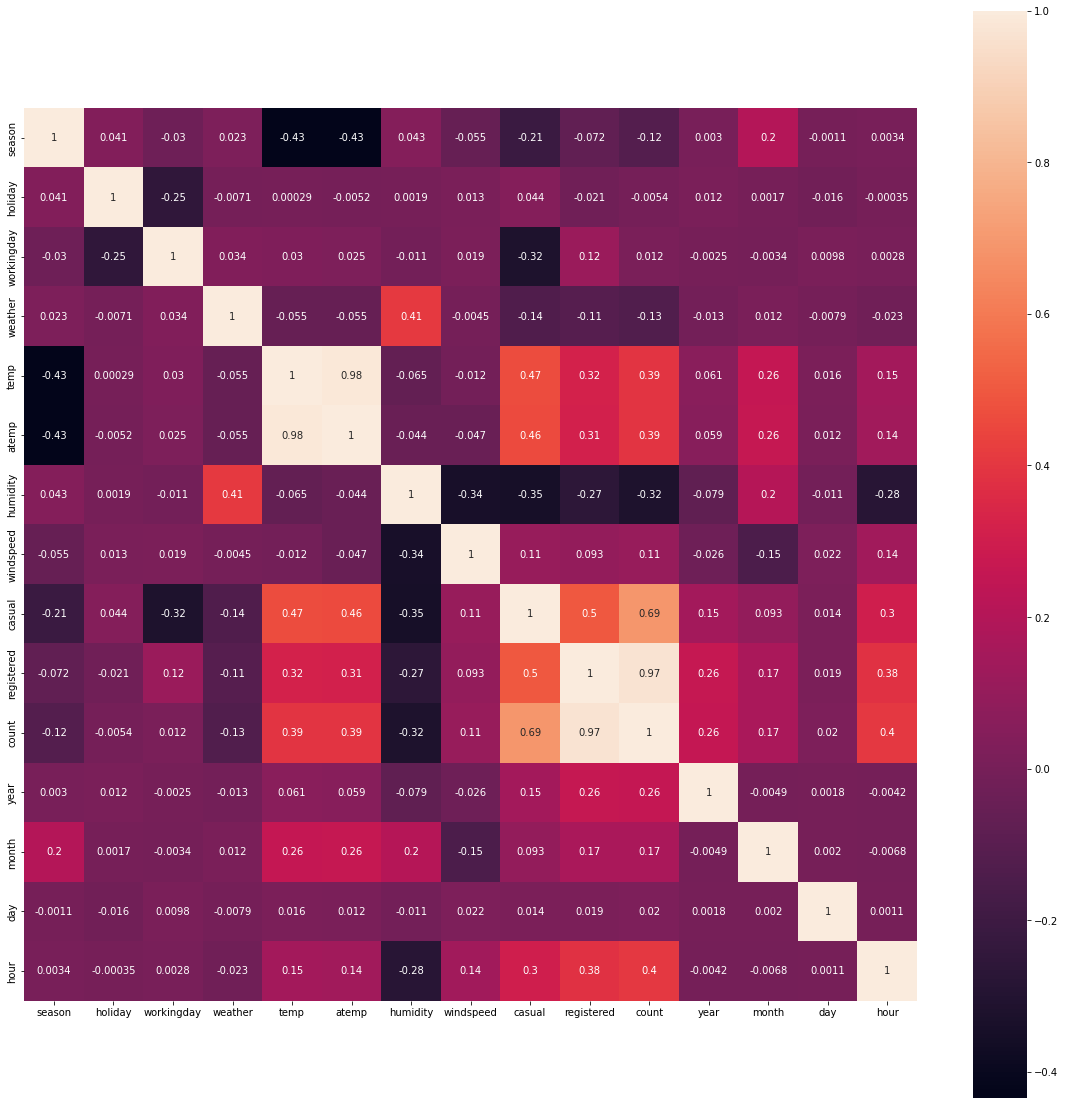

In [29]:
# 바뀐 windspeed와 상관계수 분석 
fig = plt.figure(figsize=[20,20])
ax = sns.heatmap(train.corr(),annot=True,square=True)

<AxesSubplot:xlabel='windspeed', ylabel='Density'>

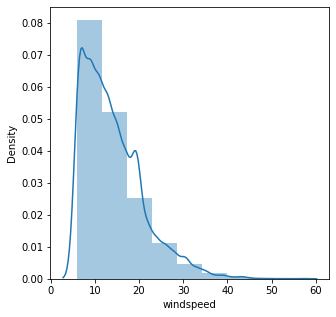

In [30]:
fig = plt.figure(figsize=[5,5])
sns.distplot(train['windspeed'],bins=np.linspace(train['windspeed'].min(),train['windspeed'].max(),10))

## 전처리 진행

In [31]:
df = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')

### 데이터를 합친상태에서 한번에 진행

In [32]:
combine = train.append(test)
combine.reset_index(inplace=True)
combine.drop('index',inplace=True,axis=1)
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   datetime    17379 non-null  object  
 1   season      17379 non-null  int64   
 2   holiday     17379 non-null  int64   
 3   workingday  17379 non-null  int64   
 4   weather     17379 non-null  int64   
 5   temp        17379 non-null  float64 
 6   atemp       17379 non-null  float64 
 7   humidity    17379 non-null  int64   
 8   windspeed   17379 non-null  float64 
 9   casual      10886 non-null  float64 
 10  registered  10886 non-null  float64 
 11  count       10886 non-null  float64 
 12  year        10886 non-null  float64 
 13  month       10886 non-null  float64 
 14  day         10886 non-null  float64 
 15  hour        10886 non-null  float64 
 16  weekday     10886 non-null  category
dtypes: category(1), float64(10), int64(5), object(1)
memory usage: 2.1+ MB


In [33]:
combine['date']= pd.to_datetime(combine['datetime'])
combine['year']= combine['date'].dt.year
combine['month']=combine['date'].dt.month
combine['day']=combine['date'].dt.day
combine['hour']=combine['date'].dt.hour
combine['weekday']=combine['date'].dt.day_name()

In [34]:
combine.weekday = combine.weekday.astype('category')

In [35]:
combine.weekday.cat.categories = ['5','1','6','0','4','2','3']

In [36]:
dataWind0 = combine[combine["windspeed"]==0]
dataWindNot0 = combine[combine["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
combine = dataWindNot0.append(dataWind0)
combine.reset_index(inplace=True)
combine.drop('index',inplace=True,axis=1)
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    17379 non-null  object        
 1   season      17379 non-null  int64         
 2   holiday     17379 non-null  int64         
 3   workingday  17379 non-null  int64         
 4   weather     17379 non-null  int64         
 5   temp        17379 non-null  float64       
 6   atemp       17379 non-null  float64       
 7   humidity    17379 non-null  int64         
 8   windspeed   17379 non-null  float64       
 9   casual      10886 non-null  float64       
 10  registered  10886 non-null  float64       
 11  count       10886 non-null  float64       
 12  year        17379 non-null  int64         
 13  month       17379 non-null  int64         
 14  day         17379 non-null  int64         
 15  hour        17379 non-null  int64         
 16  weekday     17379 non-

In [37]:
combine = pd.concat([dataWind0,dataWindNot0], axis=0)

## 인덱싱

In [38]:
# 우리가 가진 column중에 값이 일정하고 정해져 있으면 category로 변경
# 필요하지 않은 column들은 버리기
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [39]:
# categorical 하게 변환
for col in categoricalFeatureNames:
    combine[col] = combine[col].astype('category')
#for col in numericalFeatureNames:
   # combine[col] = combine[col].astype('int64')

## 데이터 분리

In [40]:
train = combine[pd.notnull(combine['count'])].sort_values(by='datetime')
test = combine[~pd.notnull(combine['count'])].sort_values(by='datetime')

#데이터 훈련시 집어 넣게 될 각각의 결과 값들
datetimecol = test['datetime']
yLabels = train['count'] #count
yLabelsRegistered = train['registered'] #등록된 사용자
yLabelsCasual = train['casual'] #임시 사용자

In [41]:
# 필요없는 컬럼 버리기
train = train.drop(dropFeatures,axis=1)
test = test.drop(dropFeatures,axis=1)

In [42]:
train['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

## RMSLE 구하기
- 오차를 제곱하여 평균한 값의 제곱근
- 0에 가까울수록 정밀도가 높다

In [43]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y), 
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

아래의 커널을 참조하여 yLabels를 로그화 하려는데 왜 np.log가 아닌 np.log1p를 활용하는가??
np.log1p는 np.log(1+x)와 동일. 이유는 만약 어떤 x값이 0인데 이를 log하게되면, (-)무한대로 수렴하기 때문에 np.log1p를 활용함. 


In [44]:
# 선형회귀모델 사용
lr = LinearRegression()

yLabelslog = np.log1p(yLabels)
#선형 모델에 우리의 데이터를 학습
lr.fit(train,yLabelslog)
#결과 값 도출
preds = lr.predict(train)
#rmsle함수의 element에 np.exp()지수 함수를 취하는 이유는 우리의 preds값에 얻어진 것은 한번 log를 한 값이기 때문에 원래 모델에는 log를 하지 않은 원래의 값을 넣기 위함임.
print('RMSLE Value For Linear Regression: {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

RMSLE Value For Linear Regression: 0.977363401299843


- 데이터 훈련시 Log값을 취하는 이유??
- 우리가 결과 값으로 투입하는 Count값이 최저 값과 최고 값의 낙폭이 너무 커서
- 만약 log를 취하지 않고 해보면 print하는 결과 값이 inf(infinity)로 뜨게 됨

<AxesSubplot:xlabel='count', ylabel='Density'>

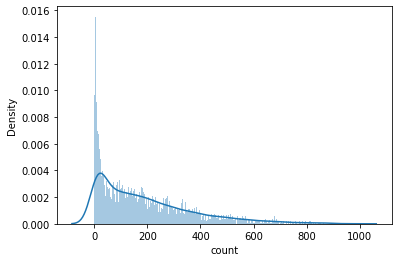

In [45]:
# count값의 분포
sns.distplot(yLabels,bins=range(yLabels.min().astype('int'),yLabels.max().astype('int')))

In [46]:
# 기존 훈련 데이터 셋의 count 갯수 
print(yLabels.count())

10886


## GridSearchCV 사용

In [47]:
#Ridge모델은 L2제약을 가지는 선형회귀모델에서 개선된 모델이며 해당 모델에서 유의 깊게 튜닝해야하는 파라미터는 alpha값이다.
ridge = Ridge()

In [48]:
ridge_params = {'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle,greater_is_better=False)
grid_ridge = GridSearchCV(ridge,ridge_params,scoring=rmsle_scorer,cv=5)

In [49]:
grid_ridge.fit(train,yLabelslog)
preds = grid_ridge.predict(train)
print(grid_ridge.best_params_)
print('RMSLE Value for Ridge Regression {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value for Ridge Regression 0.9773633767196275


In [50]:
# GridSearchCV의 변수 grid_ridge에 cv_result_를 통해 alpha값의 변화에 따라 평균값의 변화를 파악
df = pd.DataFrame(grid_ridge.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016754,0.002873,0.011477,0.000439,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.001865,-0.904066,-1.043955,-1.005283,-0.979745,-0.986983,0.046325,1
1,0.014957,0.000744,0.011333,0.000278,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.001878,-0.904065,-1.043974,-1.005278,-0.979748,-0.986988,0.046330,2
2,0.015233,0.000405,0.011557,0.000282,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.001893,-0.904063,-1.043994,-1.005273,-0.979751,-0.986995,0.046336,3
3,0.015063,0.000512,0.012084,0.001195,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.001908,-0.904062,-1.044014,-1.005267,-0.979754,-0.987001,0.046342,4
4,0.015356,0.000673,0.011706,0.000285,4,3000,"{'alpha': 4, 'max_iter': 3000}",-1.001923,-0.904061,-1.044034,-1.005262,-0.979757,-0.987008,0.046347,5


In [51]:
#Ridge모델은 선형회귀모델에서 개선된 모델이며 유의 깊게 튜닝해야하는 파라미터는 alpha값이다.
lasso = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params = {'max_iter':[3000],'alpha':alpha}
grid_lasso = GridSearchCV(lasso,lasso_params,scoring=rmsle_scorer,cv=5)
grid_lasso.fit(train,yLabelslog)
preds = grid_lasso.predict(train)
print (grid_lasso.best_params_)
print('RMSLE Value for Lasso Regression {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value for Lasso Regression 0.9774401751700389


In [52]:
rf = RandomForestRegressor()

rf_params = {'n_estimators':[1,10,100]}
grid_rf = GridSearchCV(rf,rf_params,scoring=rmsle_scorer,cv=5)
grid_rf.fit(train,yLabelslog)
preds = grid_rf.predict(train)
print('RMSLE Value for RandomForest {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

RMSLE Value for RandomForest 0.10276681084150342


In [53]:
gb = GradientBoostingRegressor()
gb_params={'max_depth':range(1,11,1),'n_estimators':[1,10,100]}
grid_gb=GridSearchCV(gb,gb_params,scoring=rmsle_scorer,cv=5)
grid_gb.fit(train,yLabelslog)
preds = grid_gb.predict(train)
print('RMSLE Value for GradientBoosting {}'.format(rmsle(np.exp(yLabelslog),np.exp(preds),False)))

RMSLE Value for GradientBoosting 0.20697635288824878


<AxesSubplot:ylabel='Density'>

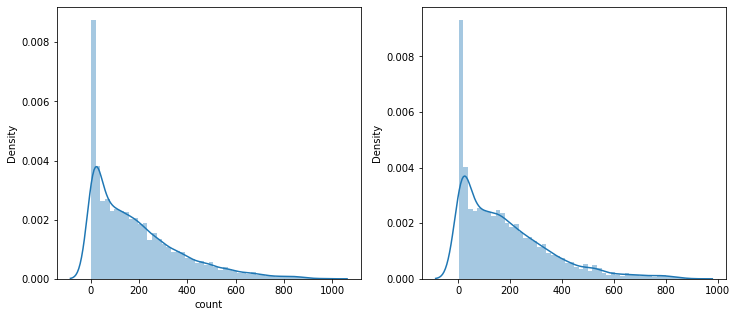

In [54]:
#test.info()
predsTest = grid_gb.predict(test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(yLabels,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [55]:
final_preds = [max(0, x) for x in np.exp(predsTest)]
submission['count'] = final_preds 
submission.to_csv('submission.csv', index=False)

In [56]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,10.881426
1,2011-01-20 01:00:00,5.863697
2,2011-01-20 02:00:00,4.181261
3,2011-01-20 03:00:00,3.009467
4,2011-01-20 04:00:00,2.965213
